In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.chdir('../../')
os.getcwd()

'/home/bunny/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import sys
import numpy as np
from tqdm import tqdm

In [6]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB16 as SCB
from omegaconf import OmegaConf as ocf

In [7]:
dataset_name = 'iemocap'
experiment_prefix = "scb16"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run0/'
data_dir = "../data/data_preprocessed/"
dataset_config_path = f'config/dataset/{dataset_name}4.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
batch_size = 2

{'name': 'iemocap', 'dataset_class': 'WaveformDataset', 'root': 'iemocap/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label4', 'feature_name': 'audio16k', 'num_classes': 4, 'label_values': ['neu', 'hap', 'sad', 'ang'], 'classnames': ['neu', 'hap', 'sad', 'ang'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [8]:
in_channels = 1
out_channels = 8
embedding_dim = 1023
num_embeddings = 384
commitment_cost = 0.25
learning_rate = 1e-4
num_tokens = 256
num_classes = 4

In [9]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [10]:
codebook_pretrained_path = f'../scb7_models/iemocap/codebook.epoch=76.pt'
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [11]:
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

In [12]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=1, loss_cls=1)
trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=4)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [13]:
trainer.setup(model=model, lr=learning_rate)

In [14]:
trainer.fit(n_epoch=50, self_supervised=False, train_task='embedding', test_n_epoch=10)

  1%|▍                                                   | 0.476833976833989/50 [07:26<390:25:33, 28381.33s/it]

Epoch: 1	Loss: 1.277 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.277]	Val_acc: 96/197 (48.73%)

Saved new best val model: ../scb16_models/iemocap/run0/model.epoch=1.step=741.loss=1.277.val_acc=0.487.pt


  3%|█▌                                                     | 1.4295366795367364/50 [19:28<9:05:47, 674.22s/it]

Correct: 434/988 (0.4393)
Saved new best test model: ../scb16_models/iemocap/run0/model.epoch=1.step=1480.test_acc=0.4393.pt
{'acc_unweighted': tensor(0.4180, device='cuda:0'),
 'acc_weighted': tensor(0.4393, device='cuda:0'),
 'f1s_unweighted': tensor(0.3610, device='cuda:0'),
 'f1s_weighted': tensor(0.3739, device='cuda:0'),
 'rocauc': tensor(0.7427, device='cuda:0'),
 'uar': tensor(0.4180, device='cuda:0'),
 'wap': tensor(0.3833, device='cuda:0')}
{'acc_detail': tensor([0.2579, 0.5614, 0.8525, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.3713, 0.4369, 0.6357, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.6628, 0.3575, 0.5068, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.2579, 0.5614, 0.8525, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.8002, 0.5758, 0.8761, 0.7188], device='cuda:0')}
tensor([[ 57, 145,  19,   0],
        [  3, 192, 147,   0],
        [  0,  32, 185,   0],
        [ 26, 168,  14,   0]], device='cuda:0')


  4%|█▉                                                 | 1.9063706563707945/50 [26:57<381:44:00, 28574.27s/it]

Epoch: 2	Loss: 0.751 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.751]	Val_acc: 86/197 (43.65%)



  6%|██▉                                                | 2.8590733590736597/50 [41:13<370:21:59, 28283.70s/it]

Epoch: 3	Loss: 1.042 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.042]	Val_acc: 96/197 (48.73%)



  8%|███▉                                                | 3.811776061776525/50 [55:28<367:15:05, 28624.29s/it]

Epoch: 4	Loss: 1.700 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.700]	Val_acc: 109/197 (55.33%)

Saved new best val model: ../scb16_models/iemocap/run0/model.epoch=4.step=5181.loss=1.700.val_acc=0.553.pt


 10%|████▊                                              | 4.76447876447939/50 [1:09:43<356:18:02, 28355.64s/it]

Epoch: 5	Loss: 0.903 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.903]	Val_acc: 102/197 (51.78%)



 11%|█████▋                                            | 5.717181467182255/50 [1:24:01<356:12:36, 28958.33s/it]

Epoch: 6	Loss: 2.403 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.403]	Val_acc: 99/197 (50.25%)



 13%|██████▊                                            | 6.66988416988512/50 [1:38:24<348:18:43, 28938.84s/it]

Epoch: 7	Loss: 0.697 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.697]	Val_acc: 107/197 (54.31%)



 15%|███████▌                                          | 7.622586872587985/50 [1:52:47<341:39:03, 29023.55s/it]

Epoch: 8	Loss: 1.270 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.270]	Val_acc: 101/197 (51.27%)



 17%|████████▋                                          | 8.57528957529085/50 [2:07:15<331:24:01, 28800.23s/it]

Epoch: 9	Loss: 0.598 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.598]	Val_acc: 111/197 (56.35%)

Saved new best val model: ../scb16_models/iemocap/run0/model.epoch=9.step=12581.loss=0.598.val_acc=0.563.pt


 19%|█████████▌                                        | 9.527992277993715/50 [2:21:38<327:53:39, 29166.31s/it]

Epoch: 10	Loss: 0.777 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.777]	Val_acc: 101/197 (51.27%)



 21%|██████████▍                                       | 10.48069498069658/50 [2:36:10<320:27:50, 29192.57s/it]

Epoch: 11	Loss: 1.552 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.552]	Val_acc: 111/197 (56.35%)



 23%|████████████                                         | 11.433397683399445/50 [2:48:36<7:29:40, 699.57s/it]

Correct: 497/988 (0.5030)
Saved new best test model: ../scb16_models/iemocap/run0/model.epoch=11.step=16280.test_acc=0.5030.pt
{'acc_unweighted': tensor(0.4577, device='cuda:0'),
 'acc_weighted': tensor(0.5030, device='cuda:0'),
 'f1s_unweighted': tensor(0.4584, device='cuda:0'),
 'f1s_weighted': tensor(0.4767, device='cuda:0'),
 'rocauc': tensor(0.8044, device='cuda:0'),
 'uar': tensor(0.4577, device='cuda:0'),
 'wap': tensor(0.5625, device='cuda:0')}
{'acc_detail': tensor([0.1991, 0.8129, 0.5161, 0.3029], device='cuda:0'),
 'f1s_detail': tensor([0.3154, 0.5972, 0.6005, 0.3206], device='cuda:0'),
 'precision_detail': tensor([0.7586, 0.4720, 0.7179, 0.3405], device='cuda:0'),
 'recall_detail': tensor([0.1991, 0.8129, 0.5161, 0.3029], device='cuda:0'),
 'rocauc_detail': tensor([0.8603, 0.7434, 0.8926, 0.7211], device='cuda:0')}
tensor([[ 44,  80,   1,  96],
        [  2, 278,  40,  22],
        [  0, 101, 112,   4],
        [ 12, 130,   3,  63]], device='cuda:0')


 24%|███████████▋                                     | 11.910231660233503/50 [2:56:16<310:04:42, 29306.62s/it]

Epoch: 12	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 99/197 (50.25%)



 26%|████████████▌                                    | 12.862934362936368/50 [3:10:50<303:26:00, 29414.30s/it]

Epoch: 13	Loss: 0.440 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.440]	Val_acc: 90/197 (45.69%)



 28%|█████████████▌                                   | 13.815637065639233/50 [3:25:28<294:10:56, 29268.33s/it]

Epoch: 14	Loss: 0.310 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.310]	Val_acc: 110/197 (55.84%)



 30%|██████████████▍                                  | 14.768339768342098/50 [3:40:08<290:28:53, 29681.64s/it]

Epoch: 15	Loss: 0.236 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.236]	Val_acc: 97/197 (49.24%)



 31%|███████████████▍                                 | 15.721042471044964/50 [3:54:52<281:37:09, 29575.85s/it]

Epoch: 16	Loss: 0.129 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.129]	Val_acc: 84/197 (42.64%)



 33%|████████████████▋                                 | 16.67374517374783/50 [4:09:36<274:50:20, 29688.91s/it]

Epoch: 17	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 111/197 (56.35%)



 35%|█████████████████▎                               | 17.626447876450694/50 [4:24:25<267:42:53, 29770.38s/it]

Epoch: 18	Loss: 0.424 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.424]	Val_acc: 92/197 (46.70%)



 37%|██████████████████▌                               | 18.57915057915356/50 [4:39:14<259:05:14, 29684.57s/it]

Epoch: 19	Loss: 0.345 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.345]	Val_acc: 108/197 (54.82%)



 39%|███████████████████▏                             | 19.531853281856424/50 [4:54:04<251:47:33, 29750.86s/it]

Epoch: 20	Loss: 0.278 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.278]	Val_acc: 105/197 (53.30%)



 41%|████████████████████▍                             | 20.48455598455929/50 [5:08:56<244:09:02, 29779.06s/it]

Epoch: 21	Loss: 1.106 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.106]	Val_acc: 99/197 (50.25%)



 43%|██████████████████████▋                              | 21.437258687262155/50 [5:21:42<5:45:56, 726.71s/it]

Correct: 545/988 (0.5516)
Saved new best test model: ../scb16_models/iemocap/run0/model.epoch=21.step=31080.test_acc=0.5516.pt
{'acc_unweighted': tensor(0.5561, device='cuda:0'),
 'acc_weighted': tensor(0.5516, device='cuda:0'),
 'f1s_unweighted': tensor(0.5482, device='cuda:0'),
 'f1s_weighted': tensor(0.5465, device='cuda:0'),
 'rocauc': tensor(0.7992, device='cuda:0'),
 'uar': tensor(0.5561, device='cuda:0'),
 'wap': tensor(0.5483, device='cuda:0')}
{'acc_detail': tensor([0.5611, 0.5088, 0.7604, 0.3942], device='cuda:0'),
 'f1s_detail': tensor([0.5905, 0.5241, 0.6600, 0.4184], device='cuda:0'),
 'precision_detail': tensor([0.6231, 0.5404, 0.5830, 0.4457], device='cuda:0'),
 'recall_detail': tensor([0.5611, 0.5088, 0.7604, 0.3942], device='cuda:0'),
 'rocauc_detail': tensor([0.8440, 0.7415, 0.8794, 0.7320], device='cuda:0')}
tensor([[124,  42,   9,  46],
        [ 19, 174,  97,  52],
        [  7,  41, 165,   4],
        [ 49,  65,  12,  82]], device='cuda:0')


 44%|█████████████████████▍                           | 21.914092664096213/50 [5:29:34<233:51:19, 29975.15s/it]

Epoch: 22	Loss: 0.652 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.652]	Val_acc: 112/197 (56.85%)

Saved new best val model: ../scb16_models/iemocap/run0/model.epoch=22.step=31821.loss=0.652.val_acc=0.569.pt


 46%|██████████████████████▍                          | 22.866795366799078/50 [5:44:32<227:13:32, 30148.01s/it]

Epoch: 23	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 105/197 (53.30%)



 48%|███████████████████████▎                         | 23.819498069501943/50 [5:59:29<219:04:37, 30124.60s/it]

Epoch: 24	Loss: 0.065 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.065]	Val_acc: 100/197 (50.76%)



 50%|████████████████████████▊                         | 24.77220077220481/50 [6:14:30<210:35:33, 30051.52s/it]

Epoch: 25	Loss: 0.414 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.414]	Val_acc: 105/197 (53.30%)



 51%|█████████████████████████▏                       | 25.724903474907673/50 [6:29:32<200:08:25, 29680.86s/it]

Epoch: 26	Loss: 0.080 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.080]	Val_acc: 104/197 (52.79%)



 53%|██████████████████████████▋                       | 26.67760617761054/50 [6:44:35<196:38:22, 30352.92s/it]

Epoch: 27	Loss: 0.134 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.134]	Val_acc: 94/197 (47.72%)



 55%|███████████████████████████                      | 27.630308880313404/50 [6:59:45<189:13:31, 30452.45s/it]

Epoch: 28	Loss: 0.118 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.118]	Val_acc: 107/197 (54.31%)



 57%|████████████████████████████▌                     | 28.58301158301627/50 [7:14:52<181:43:06, 30545.20s/it]

Epoch: 29	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 102/197 (51.78%)



 59%|████████████████████████████▉                    | 29.535714285719134/50 [7:30:08<173:42:35, 30558.38s/it]

Epoch: 30	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 101/197 (51.27%)



 61%|███████████████████████████████▋                    | 30.488416988422/50 [7:45:18<165:20:05, 30505.24s/it]

Epoch: 31	Loss: 0.025 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.025]	Val_acc: 103/197 (52.28%)



 63%|█████████████████████████████████▎                   | 31.441119691124864/50 [7:58:26<3:54:13, 757.24s/it]

Correct: 521/988 (0.5273)
{'acc_unweighted': tensor(0.5490, device='cuda:0'),
 'acc_weighted': tensor(0.5273, device='cuda:0'),
 'f1s_unweighted': tensor(0.5224, device='cuda:0'),
 'f1s_weighted': tensor(0.5155, device='cuda:0'),
 'rocauc': tensor(0.7764, device='cuda:0'),
 'uar': tensor(0.5490, device='cuda:0'),
 'wap': tensor(0.5383, device='cuda:0')}
{'acc_detail': tensor([0.6697, 0.3626, 0.7696, 0.3942], device='cuda:0'),
 'f1s_detail': tensor([0.6167, 0.4559, 0.6220, 0.3952], device='cuda:0'),
 'precision_detail': tensor([0.5714, 0.6139, 0.5219, 0.3961], device='cuda:0'),
 'recall_detail': tensor([0.6697, 0.3626, 0.7696, 0.3942], device='cuda:0'),
 'rocauc_detail': tensor([0.8363, 0.7412, 0.8588, 0.6694], device='cuda:0')}
tensor([[148,  18,  19,  36],
        [ 27, 124, 109,  82],
        [  9,  34, 167,   7],
        [ 75,  26,  25,  82]], device='cuda:0')


 64%|███████████████████████████████▎                 | 31.917953667958923/50 [8:06:28<154:43:30, 30804.61s/it]

Epoch: 32	Loss: 0.042 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.042]	Val_acc: 105/197 (53.30%)



 66%|████████████████████████████████▏                | 32.870656370661784/50 [8:21:46<145:53:11, 30660.34s/it]

Epoch: 33	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 98/197 (49.75%)



 68%|█████████████████████████████████▊                | 33.82335907336465/50 [8:37:08<139:18:50, 31003.35s/it]

Epoch: 34	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 96/197 (48.73%)



 70%|██████████████████████████████████               | 34.776061776067515/50 [8:52:29<131:07:59, 31009.03s/it]

Epoch: 35	Loss: 0.025 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.025]	Val_acc: 97/197 (49.24%)



 71%|███████████████████████████████████▋              | 35.72876447877038/50 [9:07:56<123:09:26, 31067.12s/it]

Epoch: 36	Loss: 0.035 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.035]	Val_acc: 98/197 (49.75%)



 73%|███████████████████████████████████▉             | 36.681467181473245/50 [9:23:25<115:18:18, 31166.95s/it]

Epoch: 37	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 107/197 (54.31%)



 75%|█████████████████████████████████████▋            | 37.63416988417611/50 [9:38:57<105:24:44, 30688.17s/it]

Epoch: 38	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 102/197 (51.78%)



 77%|██████████████████████████████████████▌           | 38.586872586878975/50 [9:54:33<99:42:20, 31449.77s/it]

Epoch: 39	Loss: 0.174 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.174]	Val_acc: 105/197 (53.30%)



 79%|███████████████████████████████████████▌          | 39.53957528958184/50 [10:10:08<90:54:41, 31287.62s/it]

Epoch: 40	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 99/197 (50.25%)



 81%|███████████████████████████████████████▋         | 40.492277992284706/50 [10:25:47<83:22:08, 31566.82s/it]

Epoch: 41	Loss: 0.032 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.032]	Val_acc: 95/197 (48.22%)



 83%|███████████████████████████████████████████▉         | 41.44498069498757/50 [10:39:19<1:48:02, 757.75s/it]

Correct: 515/988 (0.5213)
{'acc_unweighted': tensor(0.5427, device='cuda:0'),
 'acc_weighted': tensor(0.5213, device='cuda:0'),
 'f1s_unweighted': tensor(0.5164, device='cuda:0'),
 'f1s_weighted': tensor(0.5084, device='cuda:0'),
 'rocauc': tensor(0.7800, device='cuda:0'),
 'uar': tensor(0.5427, device='cuda:0'),
 'wap': tensor(0.5262, device='cuda:0')}
{'acc_detail': tensor([0.6290, 0.3596, 0.7926, 0.3894], device='cuda:0'),
 'f1s_detail': tensor([0.5966, 0.4424, 0.6266, 0.4000], device='cuda:0'),
 'precision_detail': tensor([0.5673, 0.5748, 0.5181, 0.4112], device='cuda:0'),
 'recall_detail': tensor([0.6290, 0.3596, 0.7926, 0.3894], device='cuda:0'),
 'rocauc_detail': tensor([0.8169, 0.7339, 0.8694, 0.6999], device='cuda:0')}
tensor([[139,  27,  14,  41],
        [ 31, 123, 122,  66],
        [  7,  29, 172,   9],
        [ 68,  35,  24,  81]], device='cuda:0')


 84%|█████████████████████████████████████████▉        | 41.92181467182163/50 [10:47:33<70:15:35, 31310.98s/it]

Epoch: 42	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 99/197 (50.25%)



 86%|██████████████████████████████████████████       | 42.874517374524494/50 [11:03:14<62:15:31, 31454.96s/it]

Epoch: 43	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 103/197 (52.28%)



 88%|███████████████████████████████████████████▊      | 43.82722007722736/50 [11:19:00<54:01:26, 31507.08s/it]

Epoch: 44	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 104/197 (52.79%)



 90%|███████████████████████████████████████████▉     | 44.779922779930224/50 [11:34:47<46:03:26, 31763.32s/it]

Epoch: 45	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 99/197 (50.25%)



 91%|█████████████████████████████████████████████▋    | 45.73262548263309/50 [11:50:39<37:41:50, 31801.78s/it]

Epoch: 46	Loss: 0.016 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.016]	Val_acc: 94/197 (47.72%)



 93%|█████████████████████████████████████████████▊   | 46.685328185335955/50 [12:06:33<29:17:38, 31815.82s/it]

Epoch: 47	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 98/197 (49.75%)



 95%|███████████████████████████████████████████████▋  | 47.63803088803882/50 [12:22:30<20:55:48, 31900.65s/it]

Epoch: 48	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 93/197 (47.21%)



 97%|███████████████████████████████████████████████▌ | 48.590733590741685/50 [12:38:28<12:30:47, 31965.32s/it]

Epoch: 49	Loss: 0.027 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.027]	Val_acc: 104/197 (52.79%)



 99%|██████████████████████████████████████████████████▌| 49.54343629344455/50 [12:54:32<4:03:26, 31991.98s/it]

Epoch: 50	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 98/197 (49.75%)



100%|██████████████████████████████████████████████████████▉| 49.99951737452571/50 [13:01:47<00:00, 925.94s/it]/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████| 50.01930501931336/50 [13:02:06<-1:59:42, 938.17s/it]


In [15]:
trainer.fit(n_epoch=50, self_supervised=False, train_task='embedding', test_n_epoch=1)

  1%|▎                                                  | 0.3335584064821085/50 [08:25<629:34:34, 45633.91s/it]

Epoch: 51	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 103/197 (52.28%)



  2%|█                                                    | 0.9999999999999617/50 [22:14<15:03:09, 1105.91s/it]

Correct: 496/988 (0.5020)
{'acc_unweighted': tensor(0.4950, device='cuda:0'),
 'acc_weighted': tensor(0.5020, device='cuda:0'),
 'f1s_unweighted': tensor(0.5011, device='cuda:0'),
 'f1s_weighted': tensor(0.5043, device='cuda:0'),
 'rocauc': tensor(0.7625, device='cuda:0'),
 'uar': tensor(0.4950, device='cuda:0'),
 'wap': tensor(0.5202, device='cuda:0')}
{'acc_detail': tensor([0.4796, 0.5526, 0.4332, 0.5144], device='cuda:0'),
 'f1s_detail': tensor([0.5394, 0.5214, 0.4987, 0.4449], device='cuda:0'),
 'precision_detail': tensor([0.6163, 0.4935, 0.5875, 0.3919], device='cuda:0'),
 'recall_detail': tensor([0.4796, 0.5526, 0.4332, 0.5144], device='cuda:0'),
 'rocauc_detail': tensor([0.7958, 0.7144, 0.8296, 0.7102], device='cuda:0')}
tensor([[106,  31,   7,  77],
        [ 23, 189,  53,  77],
        [  9, 102,  94,  12],
        [ 34,  61,   6, 107]], device='cuda:0')


  3%|█▎                                                 | 1.3335584064820347/50 [30:43<616:37:19, 45613.36s/it]

Epoch: 52	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 100/197 (50.76%)



  4%|██                                                   | 1.9999999999998606/50 [44:44<15:00:46, 1125.98s/it]

Correct: 526/988 (0.5324)
{'acc_unweighted': tensor(0.5314, device='cuda:0'),
 'acc_weighted': tensor(0.5324, device='cuda:0'),
 'f1s_unweighted': tensor(0.5306, device='cuda:0'),
 'f1s_weighted': tensor(0.5326, device='cuda:0'),
 'rocauc': tensor(0.7781, device='cuda:0'),
 'uar': tensor(0.5314, device='cuda:0'),
 'wap': tensor(0.5394, device='cuda:0')}
{'acc_detail': tensor([0.4932, 0.5351, 0.6359, 0.4615], device='cuda:0'),
 'f1s_detail': tensor([0.5575, 0.5390, 0.5774, 0.4486], device='cuda:0'),
 'precision_detail': tensor([0.6412, 0.5430, 0.5287, 0.4364], device='cuda:0'),
 'recall_detail': tensor([0.4932, 0.5351, 0.6359, 0.4615], device='cuda:0'),
 'rocauc_detail': tensor([0.8207, 0.7325, 0.8346, 0.7245], device='cuda:0')}
tensor([[109,  37,  17,  58],
        [ 16, 183,  88,  55],
        [  5,  63, 138,  11],
        [ 40,  54,  18,  96]], device='cuda:0')


  5%|██▍                                                | 2.3335584064819335/50 [53:15<615:26:27, 46481.08s/it]

Epoch: 53	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 102/197 (51.78%)



  6%|███                                                | 2.9999999999997593/50 [1:07:15<14:55:56, 1143.76s/it]

Correct: 512/988 (0.5182)
{'acc_unweighted': tensor(0.5352, device='cuda:0'),
 'acc_weighted': tensor(0.5182, device='cuda:0'),
 'f1s_unweighted': tensor(0.5193, device='cuda:0'),
 'f1s_weighted': tensor(0.5129, device='cuda:0'),
 'rocauc': tensor(0.7707, device='cuda:0'),
 'uar': tensor(0.5352, device='cuda:0'),
 'wap': tensor(0.5236, device='cuda:0')}
{'acc_detail': tensor([0.6154, 0.3918, 0.6912, 0.4423], device='cuda:0'),
 'f1s_detail': tensor([0.6031, 0.4597, 0.5894, 0.4249], device='cuda:0'),
 'precision_detail': tensor([0.5913, 0.5560, 0.5137, 0.4089], device='cuda:0'),
 'recall_detail': tensor([0.6154, 0.3918, 0.6912, 0.4423], device='cuda:0'),
 'rocauc_detail': tensor([0.8227, 0.7247, 0.8437, 0.6917], device='cuda:0')}
tensor([[136,  24,  14,  47],
        [ 28, 134, 103,  77],
        [  8,  50, 150,   9],
        [ 58,  33,  25,  92]], device='cuda:0')


  6%|███▎                                                | 3.241390952059154/50 [1:12:53<17:16:16, 1329.72s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7984ec4931c0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  6%|███▎                                                | 3.241728561782314/50 [1:12:53<17:31:23, 1349.14s/it]

KeyboardInterrupt



In [16]:
from pprint import pprint
from einops import reduce
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [17]:
trainer.load_best_model(val_model=True)

Loaded: ../scb16_models/iemocap/run0/model.epoch=22.step=31821.loss=0.652.val_acc=0.569.pt


In [18]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

Correct: 536/988 (0.5425)


In [19]:
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.5303),
 'acc_weighted': tensor(0.5425),
 'f1s_unweighted': tensor(0.5392),
 'f1s_weighted': tensor(0.5438),
 'rocauc': tensor(0.7886),
 'uar': tensor(0.5303),
 'wap': tensor(0.5613)}
{'acc_detail': tensor([0.4480, 0.6257, 0.5714, 0.4760]),
 'f1s_detail': tensor([0.5425, 0.5684, 0.6019, 0.4439]),
 'precision_detail': tensor([0.6875, 0.5207, 0.6359, 0.4160]),
 'recall_detail': tensor([0.4480, 0.6257, 0.5714, 0.4760]),
 'rocauc_detail': tensor([0.8237, 0.7441, 0.8702, 0.7164])}
tensor([[ 99,  41,   7,  74],
        [  9, 214,  58,  61],
        [  6,  83, 124,   4],
        [ 30,  73,   6,  99]])


<Axes: xlabel='Predicted', ylabel='Actual'>

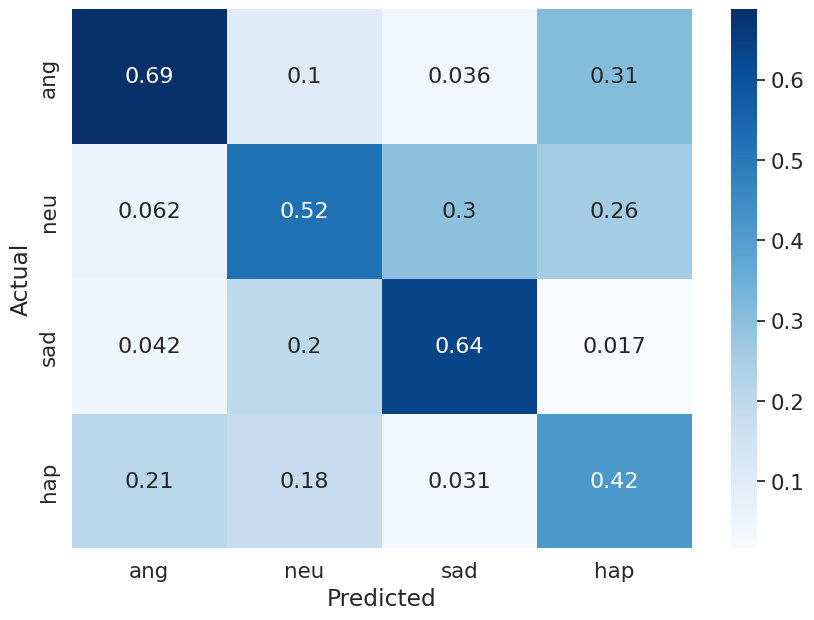

In [20]:
labels = dataset_config.target_labels
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

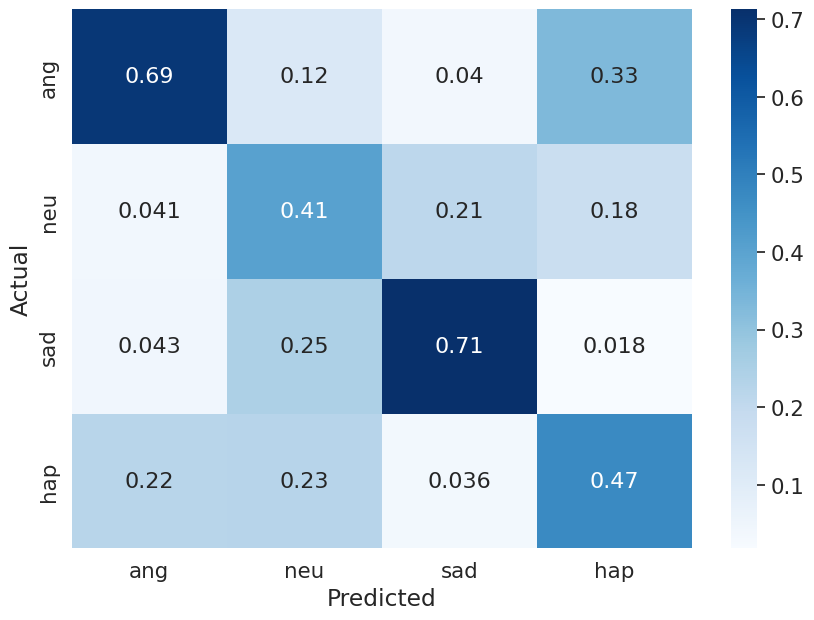

In [21]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [22]:
print(trainer.best_test_model_path)

../scb16_models/iemocap/run0/model.epoch=21.step=31080.test_acc=0.5516.pt


In [23]:
me = {'acc_unweighted': torch.tensor(0.5561),
 'acc_weighted': torch.tensor(0.5516),
 'f1s_unweighted': torch.tensor(0.5482),
 'f1s_weighted': torch.tensor(0.5465),
 'rocauc': torch.tensor(0.7992),
 'uar': torch.tensor(0.5561),
 'wap': torch.tensor(0.5483)}

med = {'acc_detail': torch.tensor([0.5611, 0.5088, 0.7604, 0.3942]),
 'f1s_detail': torch.tensor([0.5905, 0.5241, 0.6600, 0.4184]),
 'precision_detail': torch.tensor([0.6231, 0.5404, 0.5830, 0.4457]),
 'recall_detail': torch.tensor([0.5611, 0.5088, 0.7604, 0.3942]),
 'rocauc_detail': torch.tensor([0.8440, 0.7415, 0.8794, 0.7320])}

cm = torch.tensor([[124,  42,   9,  46],
        [ 19, 174,  97,  52],
        [  7,  41, 165,   4],
        [ 49,  65,  12,  82]])

<Axes: xlabel='Predicted', ylabel='Actual'>

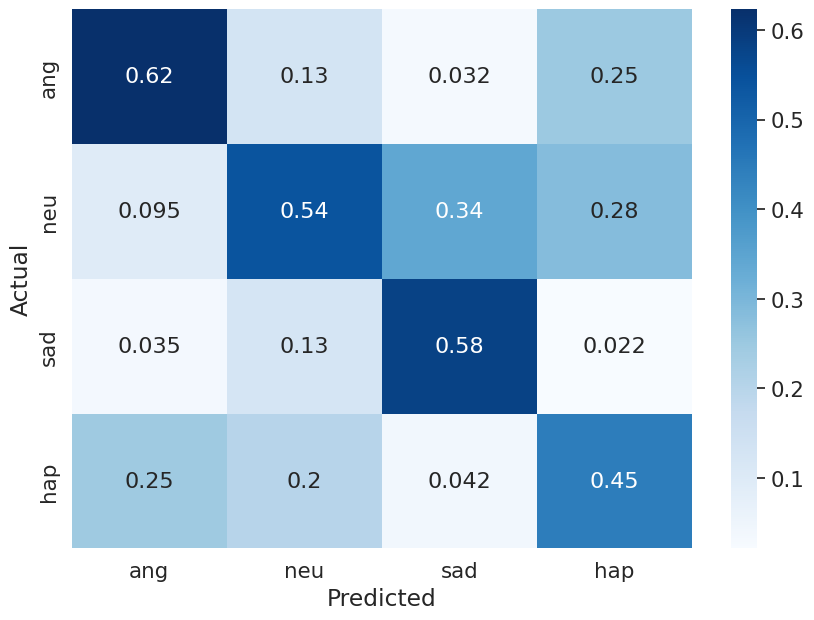

In [24]:
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

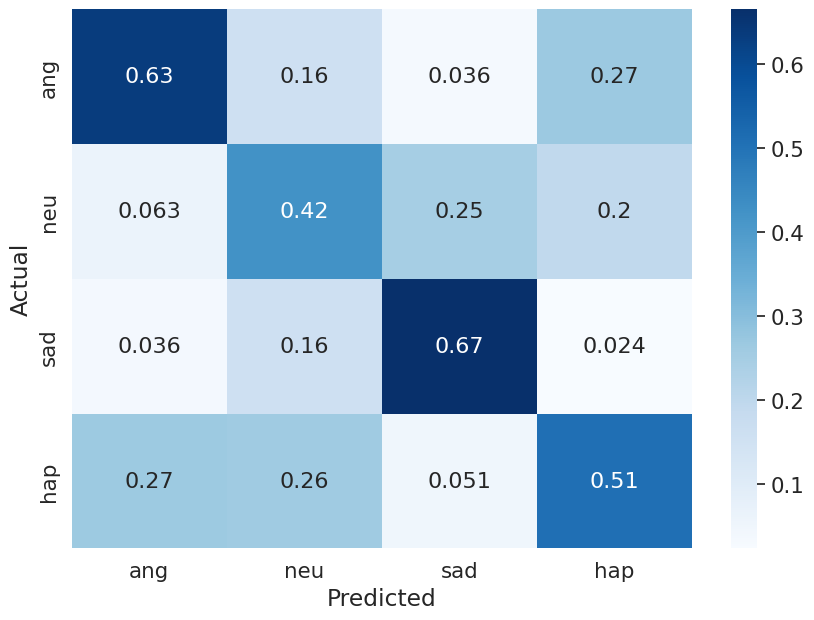

In [25]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [26]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

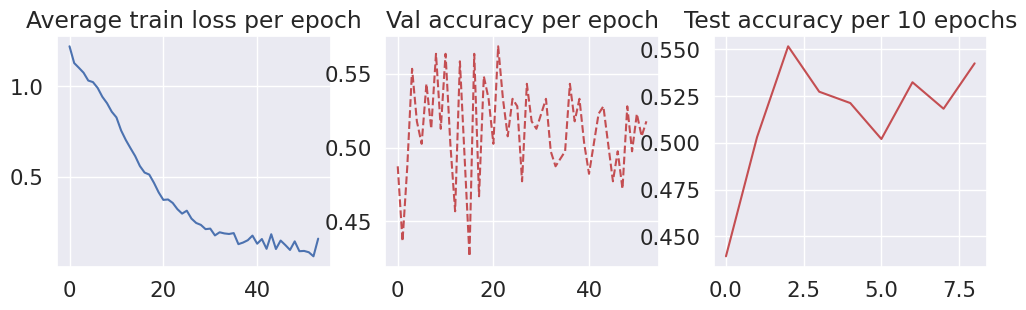

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

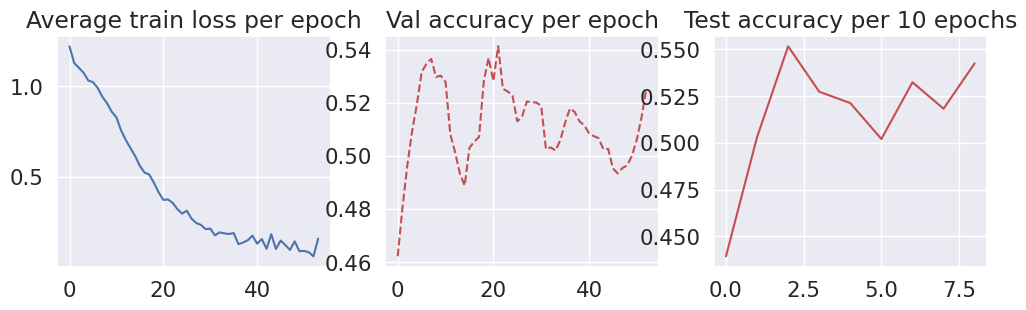

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

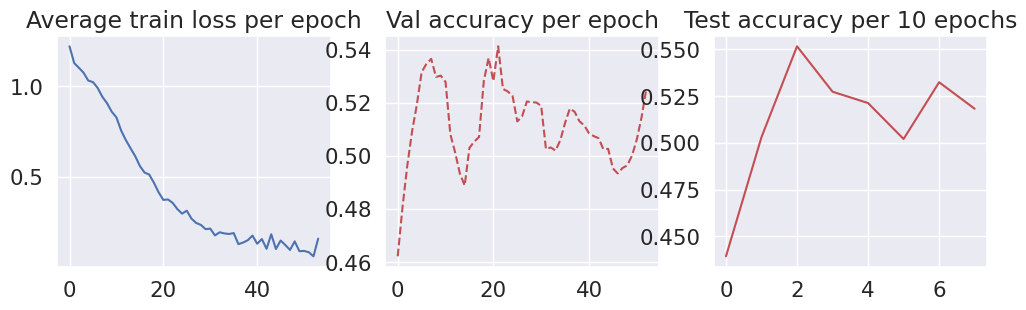

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy[:-1], color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [30]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': trainer.best_test_model_path
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")

## run1

In [31]:
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run1/'
trainer.log_dir = log_dir

In [32]:
iconnet_config = ocf.load(iconnet_config_path)
iconnet_config.fe.n_channel = [456]
iconnet_config.fe.window_k = [2]
iconnet_config.cls = {'n_block': 1, 'n_hidden_dim': [512,], 'norm_type': 'LayerNorm'}
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [511], 'stride': [2], 'window_k': [2], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 1, 'n_hidden_dim': [512], 'norm_type': 'LayerNorm'}}


In [33]:
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [34]:
trainer.setup(model=model, lr=learning_rate)

In [ ]:
trainer.fit(n_epoch=30, self_supervised=False, train_task='embedding', test_n_epoch=10)

  1%|▎                                                     | 0.17181467181467153/30 [03:04<8:09:33, 984.77s/it]

In [ ]:
trainer.fit(n_epoch=30, self_supervised=False, train_task='embedding', test_n_epoch=1)

In [ ]:
trainer.load_best_model(val_model=True)

In [ ]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

In [ ]:
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

In [ ]:
trainer.load(log_dir + "model.epoch=71.step=7100.pt")

In [ ]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

In [ ]:
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

In [ ]:
trainer.fit(n_epoch=20, self_supervised=False, train_task='embedding', test_n_epoch=1)

In [ ]:
trainer.load_best_model(val_model=False)
metrics, metrics_details, confusion_matrix = trainer.test_step()
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

In [ ]:
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [ ]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [ ]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(savgol_filter(train_losses, 10, 1), color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy[:-1], color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [ ]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': trainer.best_test_model_path
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")